<a href="https://colab.research.google.com/github/heerboi/lion-vs-tiger/blob/main/lion-vs-tiger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# DLE305 A3 Classifying Lions and Tigers Project

# HEER BIPIN PATEL - A00100785
# CRISTIAN CAMILO CRUZ CASTELLANOS - A00075421
# Razat Siwakoti - A00046635
#Bastian Albornoz - A00082303

# Lecturer: Ali El Romeh

# Date: 12/08/2024


# INSTRUCTIONS TO RUN:

# 1) Run the import statements
# 2) Insert Kaggle API key and associated username as secrets in the notebook
#     to fetch the Dogs vs. Cats dataset
#    ============ OR =============
# 2) Extract the cat and dog images manually into "./train/" directory
# 3) Download gdown console command to download  lion and tiger images from drive
#    ============ OR =============
# 3) Extract images into 'images/lion/' directory for lion and 'images/tiger/' for tigers
# 3) Autorun the whole code and everything should work!

Restart after updating the below modules
This is required as Google Colab has older versions that are incompatible

In [ ]:
!pip install -U tensorflow
!pip install -U keras
!pip install -U pydot
!pip install -U graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 906.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 660.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 21.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow

In [ ]:
# Importing Tensorflow to create our models
import tensorflow as tf

# Importing seaborn for data visualization
import seaborn as sns

# Importing numpy for vectors, matrices, and mathematical operations
import numpy as np

# Image class to open, read, and edit images
from PIL import Image

# To find path names using patterns
import glob

import os

from collections import defaultdict

# Keras is the deep learning framework of Tensorflow, specially for NNs
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model, to_categorical
from keras.models import Model

# This function purely for pretty printing progress bars
# 0 ======= 100
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# Fetching data

In [ ]:
!pip install -q kaggle

# The following code is to login to Kaggle and fetch the dataset

# Skip steps if dataset images already exist in directory './train'

from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

SecretNotFoundError: Secret KAGGLE_KEY does not exist.

In [ ]:
!kaggle competitions download -c dogs-vs-cats
!gdown 1wYa-FKdZSoQPdBmpGxNUeHAVkc68e-kL
!unzip 'tigers_and_lions.zip'
!unzip 'dogs-vs-cats.zip'
!unzip 'train.zip'

# Preprocessing images

In [ ]:
# The following function takes an image path, resizes (if provided), and returns a matrix of pixels
def pixels_from_path(file_path, resize = True):
    image = Image.open(file_path)

    if resize:
      image = image.resize((175, 175))

    # Create array containing pixels from the image
    image_array = np.array(image)

    # Matrix of pixel RGB values
    return image_array

# The following function takes the amount of images, and the path to images.
# It randomly chooses the images from the dataset, resizes them, and returns them as a numpy array

def return_images(size, path_to_images):
  # Recursively return paths that match the path specified
  image_paths = glob.glob(f"{path_to_images}*")

  # initialize img array
  img_matrix_array = []

  # This is required because the datasets might contain corrupted or improper images

  # Run loop until enough images are obtained
  while len(img_matrix_array) < size:

    # Sample a random index from the image paths
    img_index = np.random.choice(image_paths)
    # Remove the sampled index to make sure it doesn't repeat
    image_paths.remove(img_index)
    # Resize and obtain matrix
    img_matrix = pixels_from_path(img_index, True)

    # If image does not have three dimensions
    if len(img_matrix.shape) != 3:
      continue

    # If channel dimensions is not 3
    if img_matrix.shape[2] != 3:
      continue

    img_matrix_array.append(img_matrix)

  # Return array when required number of images are reached
  return np.asarray(img_matrix_array)

In [ ]:
# DEFINING CONSTANTS

# 10% of the data will automatically be used for validation
VALIDATION_SIZE = 512

IMG_SIZE = (175, 175)

# 3 color channels = RGB
NUM_CHANNELS = 3

# We use 2048 pictures as our sample size for the cats and dogs (because we have more images)
#                                                               (and because the base model needs more data)
SAMPLE_SIZE1 = 2048

# We use 512 images as our sample for lion and tiger because we have less data on that
SAMPLE_SIZE2 = 512

# Epoch size - Total number of times model is trained on the whole training set
EPOCH_SIZE = 10

# Batch size - Total number of images used in one single training step
BATCH_SIZE = 32

In [ ]:
print("Loading cat images....")
cat_images = return_images(size=SAMPLE_SIZE1 + VALIDATION_SIZE, path_to_images='train/cat.')
print("Loading dog images....")
dog_images = return_images(size=SAMPLE_SIZE1 + VALIDATION_SIZE, path_to_images='train/dog.')
print("Loading lion images....")
lion_images = return_images(size=SAMPLE_SIZE2 + VALIDATION_SIZE, path_to_images='images/lion/')
print("Loading tiger images....")
tiger_images = return_images(size=SAMPLE_SIZE2 + VALIDATION_SIZE, path_to_images='images/tiger/')

Loading cat images....
Loading dog images....
Loading lion images....
Loading tiger images....


In [ ]:
# Load images for training and validation from the earlier sampled images
print("Loading cat images for training and validation...")
cat_train_set = cat_images[:SAMPLE_SIZE1]
cat_valid_set = cat_images[-VALIDATION_SIZE:]

print("Loading dog images for training and validation...")
dog_train_set = dog_images[:SAMPLE_SIZE1]
dog_valid_set = dog_images[-VALIDATION_SIZE:]

print("Loading lion images for training and validation...")
lion_train_set = lion_images[:SAMPLE_SIZE2]
lion_valid_set = lion_images[-VALIDATION_SIZE:]

print("Loading tiger images for training and validation...")
tiger_train_set = tiger_images[:SAMPLE_SIZE2]
tiger_valid_set = tiger_images[-VALIDATION_SIZE:]

Loading cat images for training and validation...
Loading dog images for training and validation...
Loading lion images for training and validation...
Loading tiger images for training and validation...


In [ ]:
# Create input and output label training data set
# One dataset to train the base model on just cats and dogs

X_train_cats_dogs = np.concatenate([dog_train_set, cat_train_set])
X_valid_cats_dogs = np.concatenate([dog_valid_set, cat_valid_set])

# One dataset to train the model for lion, tiger
# As we must predict cats, dogs, tigers, and lions, we combine all those into one
X_train_all = np.concatenate([dog_train_set, cat_train_set, lion_train_set, tiger_train_set])
X_valid_all = np.concatenate([dog_valid_set, cat_valid_set, lion_valid_set, tiger_valid_set])

# Creates an array of labels corresponding to the images

# np.full(x, y) returns an array with the number y repeated x times

y_train_cats_dogs = np.concatenate([np.full((SAMPLE_SIZE1, 1), 0), np.full((SAMPLE_SIZE1, 1), 1)])
y_valid_cats_dogs = np.concatenate([np.full((VALIDATION_SIZE, 1), 0), np.full((VALIDATION_SIZE, 1), 1)])

# Values 2 and 3 correspond to lion and tiger respectively
y_train_all = to_categorical(np.concatenate([y_train_cats_dogs, np.full((SAMPLE_SIZE2, 1), 2), np.full((SAMPLE_SIZE2, 1), 3)]), 4)
y_valid_all = to_categorical(np.concatenate([y_valid_cats_dogs, np.full((VALIDATION_SIZE, 1), 2), np.full((VALIDATION_SIZE, 1), 3)]), 4)

In [ ]:
# Should be equal to (SAMPLE_SIZE, IMAGE SIZE X, IMAGE SIZE Y, CHANNELS)
print(f"Cats & Dogs Training data image size: {X_train_cats_dogs.shape} ")
print(f"Cats & Dogs Training data labels: {y_train_cats_dogs.shape}")
print(f"Combined Training data image size: {X_train_all.shape} ")
print(f"Combined Training data labels: {y_train_all.shape}")

Cats & Dogs Training data image size: (4096, 175, 175, 3) 
Cats & Dogs Training data labels: (4096, 1)
Combined Training data image size: (5120, 175, 175, 3) 
Combined Training data labels: (5120, 4)


# Functions for evaluating model performance

In [ ]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [ ]:
def print_and_save_correlation(model, X, true_preds, file_name, display_labels, multiclass = False):
    predictions = model.predict(X)

    # predictions = np.asarray([predictions[0] for predictions in predictions]).reshape(-1, 1)
    # predictions = predictions.round()
    true_preds_class = np.argmax(true_preds, axis=1)
    # Prints F1 score (harmonic mean of precision and recall)
    if multiclass:
        predictions_class = np.argmax(predictions, axis=1)
        f1 = f1_score(true_preds_class, predictions_class, average='macro')
    else:
        f1 = f1_score(true_preds, np.round(predictions))
    print(f"The F1 score for this model is {f1}.")

    # Prints a confusion matrix by comparing the true labels with the predicted labels
    # Confusion matrix is a matrix showing how many correct and false predictions the model made in each category
    if multiclass:
        conf_matrix = ConfusionMatrixDisplay.from_predictions(true_preds_class, predictions_class, display_labels = display_labels)
    else:
        conf_matrix = ConfusionMatrixDisplay.from_predictions(true_preds, np.round(predictions), display_labels = display_labels)
    # If out folder does not exist, make out folder
    if not os.path.exists('./out'):
        os.mkdir('./out')
    conf_matrix.figure_.savefig(f'./out/{file_name}_conf_matrix.jpeg')

In [ ]:
def print_and_save_curves(model, X_val, y_val, file_name, history, multiclass = False, class_names = None):
    predictions = model.predict(X_val)

    # Initialize the figure and subplots
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 15))

    # If out folder does not exist, make out folder
    if not os.path.exists('./out'):
        os.mkdir('./out')

    # Plotting Train vs. Validation set loss per epoch
    # Useful to gauge overfitting
    ax1.plot(history['loss'])
    ax1.plot(history['val_loss'])
    ax1.set_title('Model Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['train', 'val'], loc='upper left')
    ax1.grid(True)

    # Graphs and saves the Receiver Operating Characteristic (ROC) curve

    # FPR = False Positive Rate
    # TPR = True Positive Rate
    if multiclass:

        # Assuming y_val contains the labels in integer form and predictions contain probabilities
        n_classes = predictions.shape[1]
        # Convert integer labels to one-hot encoding
        y_val_binarized = label_binarize(y_val, classes=range(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_val_binarized[:, i], predictions[:, i])
            roc_auc = auc(fpr, tpr)
            ax2.plot(fpr, tpr, label=f'Class {class_names[i]} (area = {roc_auc:.2f})')
        ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.legend(loc='lower right')
    else:
        fpr, tpr, _ = roc_curve(y_val, predictions)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.legend(loc='lower right')
    ax2.grid(True)

    # Graphs and saves the Precision-Recall Curve
    if multiclass:
        # Prints individual graph for each class performance
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(y_val_binarized[:, i], predictions[:, i])
            ax3.plot(recall, precision, label=f'Class {class_names[i]}')
        ax3.set_title('Precision-Recall Curve')
        ax3.set_xlabel('Recall')
        ax3.set_ylabel('Precision')
        ax3.legend(loc='lower left')
    else:
        precision, recall, _ = precision_recall_curve(y_val, predictions)
        ax3.plot(recall, precision, label='Precision-Recall curve')
        ax3.set_title('Precision-Recall Curve')
        ax3.set_xlabel('Recall')
        ax3.set_ylabel('Precision')
        ax3.legend(loc='lower left')

    ax3.grid(True)


    # Plotting Train vs. Validation set accuracy per epoch
    # Useful to gauge overfitting

    ax4.plot(history['accuracy'])
    ax4.plot(history['val_accuracy'])
    ax4.set_title('Model Accuracy')
    ax4.set_ylabel('Accuracy')
    ax4.set_xlabel('Epoch')
    ax4.legend(['train', 'val'], loc='upper left')
    ax4.grid(True)
    plt.tight_layout()
    fig.savefig(f"./out/metrics_{file_name}.jpeg")
    plt.tight_layout()
    plt.show()

In [ ]:
import pickle as pkl
def save_model(model, file_name, history):
    if not os.path.exists('./models'):
        os.mkdir('./models')
    model.save(f"./models/{file_name}.keras")
    with open(f"./models/train_hist_{file_name}", "wb") as hist:
        pkl.dump(history, hist)

# Training CNN on cats and dogs

## Training an initial CNN on cats and dogs

In [ ]:
# Important module for implementing regularization
from keras import regularizers, activations
from keras.callbacks import EarlyStopping

# L1 penalty - Lasso (Feature Selection)
l1 = regularizers.l1(0.01)

# L2 penalty - Ridge (Reduce weight sizes for generalization)
l2 = regularizers.l2(1e-4)

# L1 + L2 penalty
l1_l2 = regularizers.l1_l2(l1=1e-6, l2=1e-5)

# Early stopping stops training the model after validation performance does not improve
# Saves lot of training time!
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
from keras.layers import BatchNormalization, SeparableConv2D, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, Rescaling

In [ ]:
#### IF YOU DO NOT NEED TO TRAIN THE MODEL
#### AND WANT TO LOAD IT FROM THE FOLDER
#### UNCOMMENT THE CODE BELOW AND RUN IT

cnn_model_cats_dogs = keras.models.load_model('./models/cnn_model_cats_dogs.keras')
with open('./models/train_hist_cnn_model_cats_dogs', 'rb') as pickle_file:
    history = pkl.load(pickle_file)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 175, 175, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 173, 173, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 173, 173, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 173, 173, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 86, 86, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 84, 84, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 84, 84, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 42, 42, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 40, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 40, 40, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,785,889 (10.63 MB)

 Trainable params: 2,785,409 (10.63 MB)

 Non-trainable params: 480 (1.88 KB)

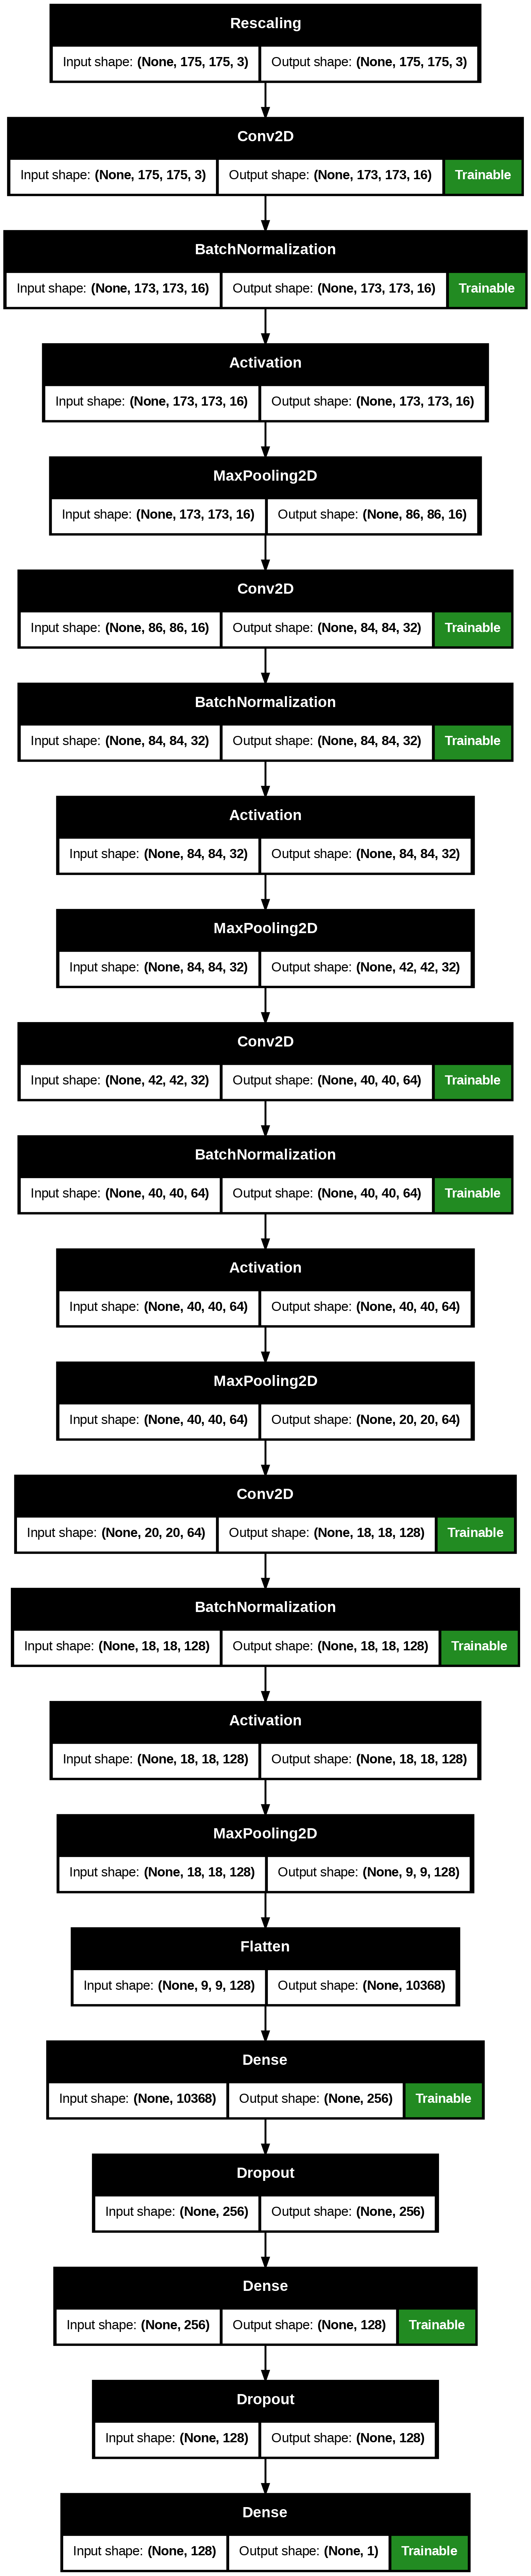

In [ ]:
#### IF YOU ARE TRAINING THE MODEL FROM SCRATCH, EXECUTE THE TWO CODE BLOCKS BELOW
# Fully Connected Layer Size
FC_LAYER_SIZE = 256

cnn_model_cats_dogs = keras.Sequential(
    [
        keras.Input(shape = (175, 175, 3)),
        Rescaling(scale=1./255),
        Conv2D(filters=16, kernel_size=3, kernel_regularizer = l2),
        BatchNormalization(epsilon=1e-6),
        Activation(activations.relu),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=32, kernel_size=3, kernel_regularizer = l2),
        BatchNormalization(epsilon=1e-6),
        Activation(activations.relu),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=3, kernel_regularizer = l2),
        BatchNormalization(epsilon=1e-6),
        Activation(activations.relu),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=128, kernel_size=3, kernel_regularizer = l2),
        BatchNormalization(epsilon=1e-6),
        Activation(activations.relu),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(FC_LAYER_SIZE, activation='relu', kernel_regularizer = l2),
        Dropout(0.4),
        Dense(FC_LAYER_SIZE // 2, activation='relu', kernel_regularizer = l2),
        Dropout(0.4),
        Dense(1, activation="sigmoid")
    ]
)

cnn_model_cats_dogs.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
    loss = "binary_crossentropy",
    metrics = ['accuracy'])

cnn_model_cats_dogs.summary()

plot_model(cnn_model_cats_dogs, show_shapes = True, show_trainable = True, to_file='./out/cnn_model_cats_dogs_summary.png', dpi = 200)

In [ ]:
history = cnn_model_cats_dogs.fit(X_train_cats_dogs,
    y_train_cats_dogs,
    batch_size = BATCH_SIZE,
    shuffle = True,
    epochs = EPOCH_SIZE * 2,
    # We pass it validation data to
    # monitor loss and entropy during model training
    # Useful to plot graphs later!
    validation_data = (X_valid_cats_dogs, y_valid_cats_dogs),
    callbacks = [early_stopping])

history = history.history

Epoch 1/20


KeyboardInterrupt: 

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step
The F1 score for this model is 0.81994459833795.
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 585ms/step


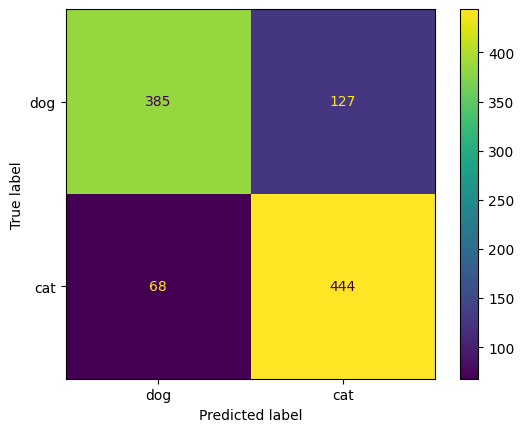

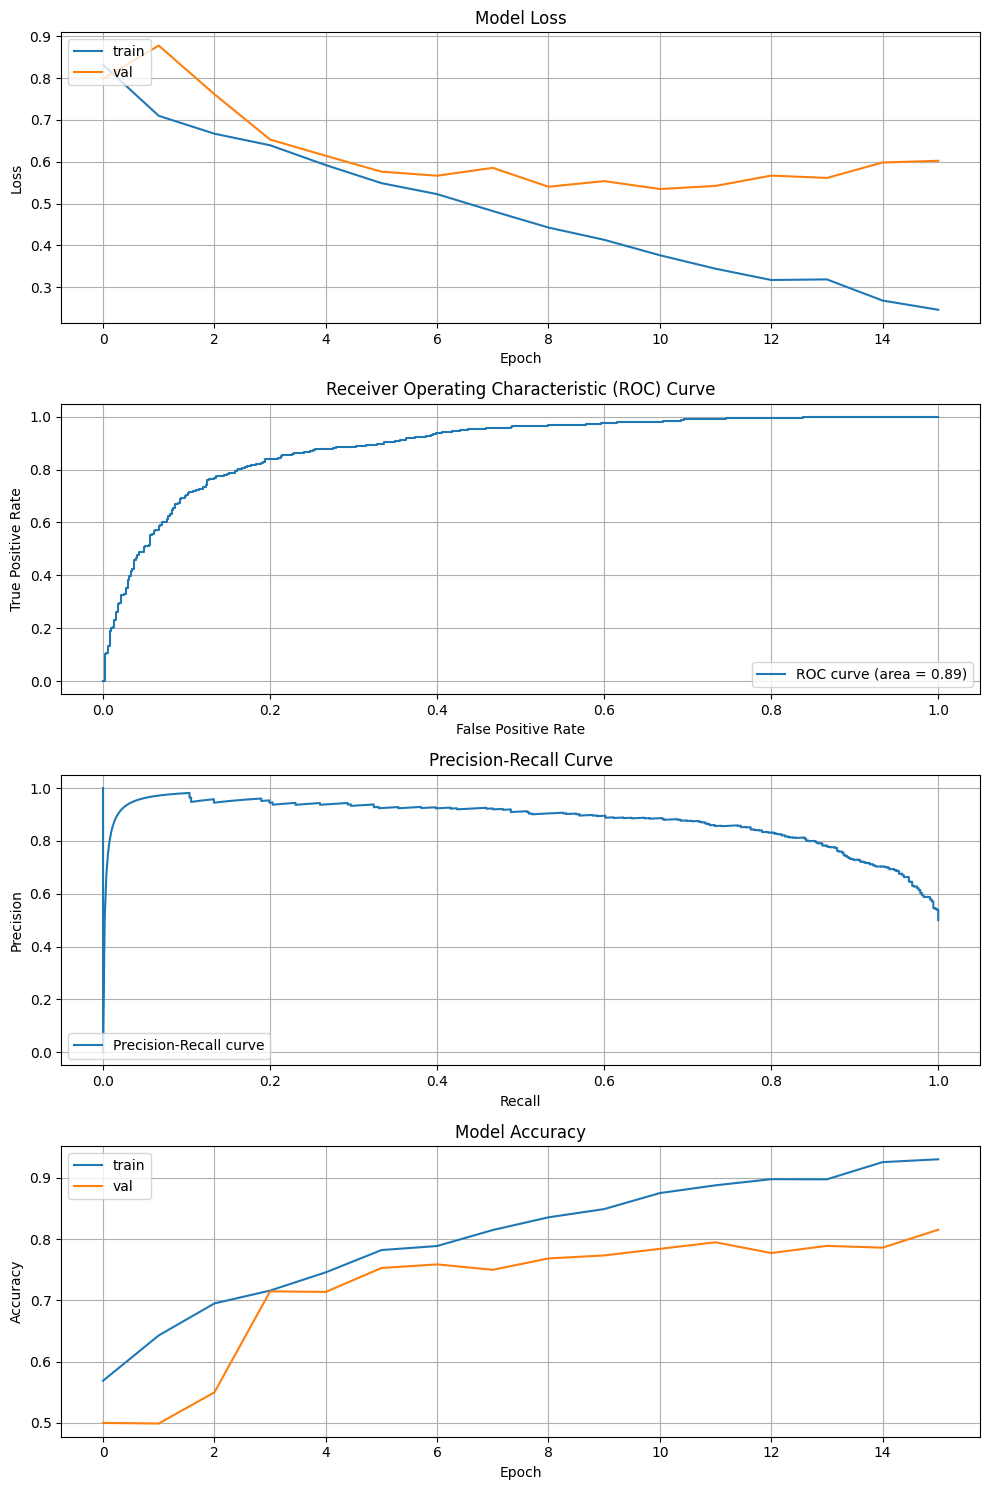

In [ ]:
print_and_save_correlation(cnn_model_cats_dogs, X_valid_cats_dogs, y_valid_cats_dogs, 'cnn_model_cats_dogs', ['dog', 'cat'])
print_and_save_curves(cnn_model_cats_dogs, X_valid_cats_dogs, y_valid_cats_dogs, 'cnn_model_cats_dogs', history)

We can see that the model starts overfitting after 8-10 epochs. This is why using early stopping is beneficial.

It saved the model from overfitting too much

In [ ]:
save_model(cnn_model_cats_dogs, 'cnn_model_cats_dogs', history)

# Training CNN on lions and tigers

## Performing Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Keras offers the Image Data Generator for augmenting images
# It can be used as a generator that directly outputs image files in batches
# or takes in input of numpy arrays and modifies those

# We specify what modifications we want to see on the images, such as rotation, shift, flip, zoom, etc.
img_aug = ImageDataGenerator(
        rotation_range=2, # rotation
        width_shift_range=0.1, # horizontal shift
        height_shift_range=0.1, # vertical shift
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.8,1.2]) # brightness

### Inspecting augmented images

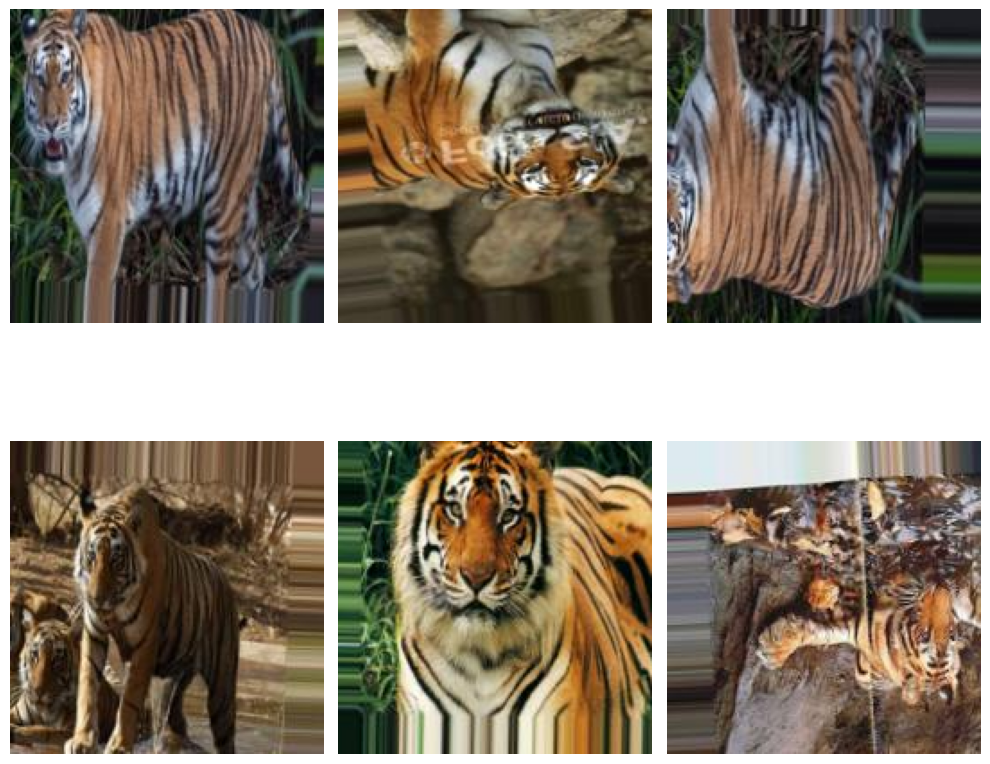

<Figure size 640x480 with 0 Axes>

In [ ]:
import random as rand

# Chooses a random image
random_image = rand.choice(X_train_all)

# Flow returns an image generator that generates images on the fly
# It will save them in the "out" directory with the image prefix
image_gen = img_aug.flow(random_image.reshape((1, 175, 175, 3)), batch_size=1, save_to_dir="./out",
	save_prefix="image", save_format="jpg")

# We are generating five images
num_imgs = 0
for img in image_gen:
    num_imgs += 1
    if num_imgs == 6:
        break

# List of the augmented image paths
image_paths = glob.glob('./out/image_0_*')[:6]

# Create 2x3 subplots (total 6 plots) to plot the images
fig, axs = plt.subplots(2, 3, figsize = (10, 10))

# Loop over all the axes
for i, ax in enumerate(axs.flat):

    # Plot an image in one of the subplot
    ax.imshow(Image.open(image_paths[i]))
    ax.axis('off')  # Hide the axes for a cleaner look

# Adjust layout to avoid overlapping
plt.tight_layout()

# Display the grid
plt.show()
plt.savefig("data_aug_examples.jpeg")

# Performing Transfer Learning from the Cats & Dogs model

### Without Augmented Images

In [ ]:
#### IF YOU DO NOT NEED TO TRAIN THE MODEL
#### AND WANT TO LOAD IT FROM THE FOLDER
#### UNCOMMENT THE CODE BELOW AND RUN IT

cnn_model_cats_dogs = keras.models.load_model('./models/cnn_model_cats_dogs.keras')
with open('./models/train_hist_cnn_model_cats_dogs', 'rb') as pickle_file:
    history = pkl.load(pickle_file)

cnn_model_lion_tiger = keras.models.load_model('./models/cnn_model_lion_tiger.keras')
with open('./models/train_hist_cnn_model_lion_tiger', 'rb') as pickle_file:
    lion_tiger_history = pkl.load(pickle_file)

In [ ]:
# Extracts the conv2d/feature extraction layers from the cats and dogs cnn
cnn_cats_and_dogs_conv = Model(inputs = cnn_model_cats_dogs.inputs, outputs = cnn_model_cats_dogs.layers[-6].output, name = "cats_and_dogs_conv")

# As we do not want to retrain the convolutions, this will turn off the ability to train them
cnn_cats_and_dogs_conv.trainable = False


FC_LAYER_SIZE = 1024


Model: "cats_and_dogs_conv"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 175, 175, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 175, 175, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 173, 173, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 173, 173, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 173, 173, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 86, 86, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 84, 84, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 84, 84, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 42, 42, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 40, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 40, 40, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 98,400 (384.38 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 98,400 (384.38 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ cats_and_dogs_conv (Functional)      │ (None, 10368)               │          98,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │      10,617,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,243,108 (42.89 MB)

 Trainable params: 11,144,708 (42.51 MB)

 Non-trainable params: 98,400 (384.38 KB)

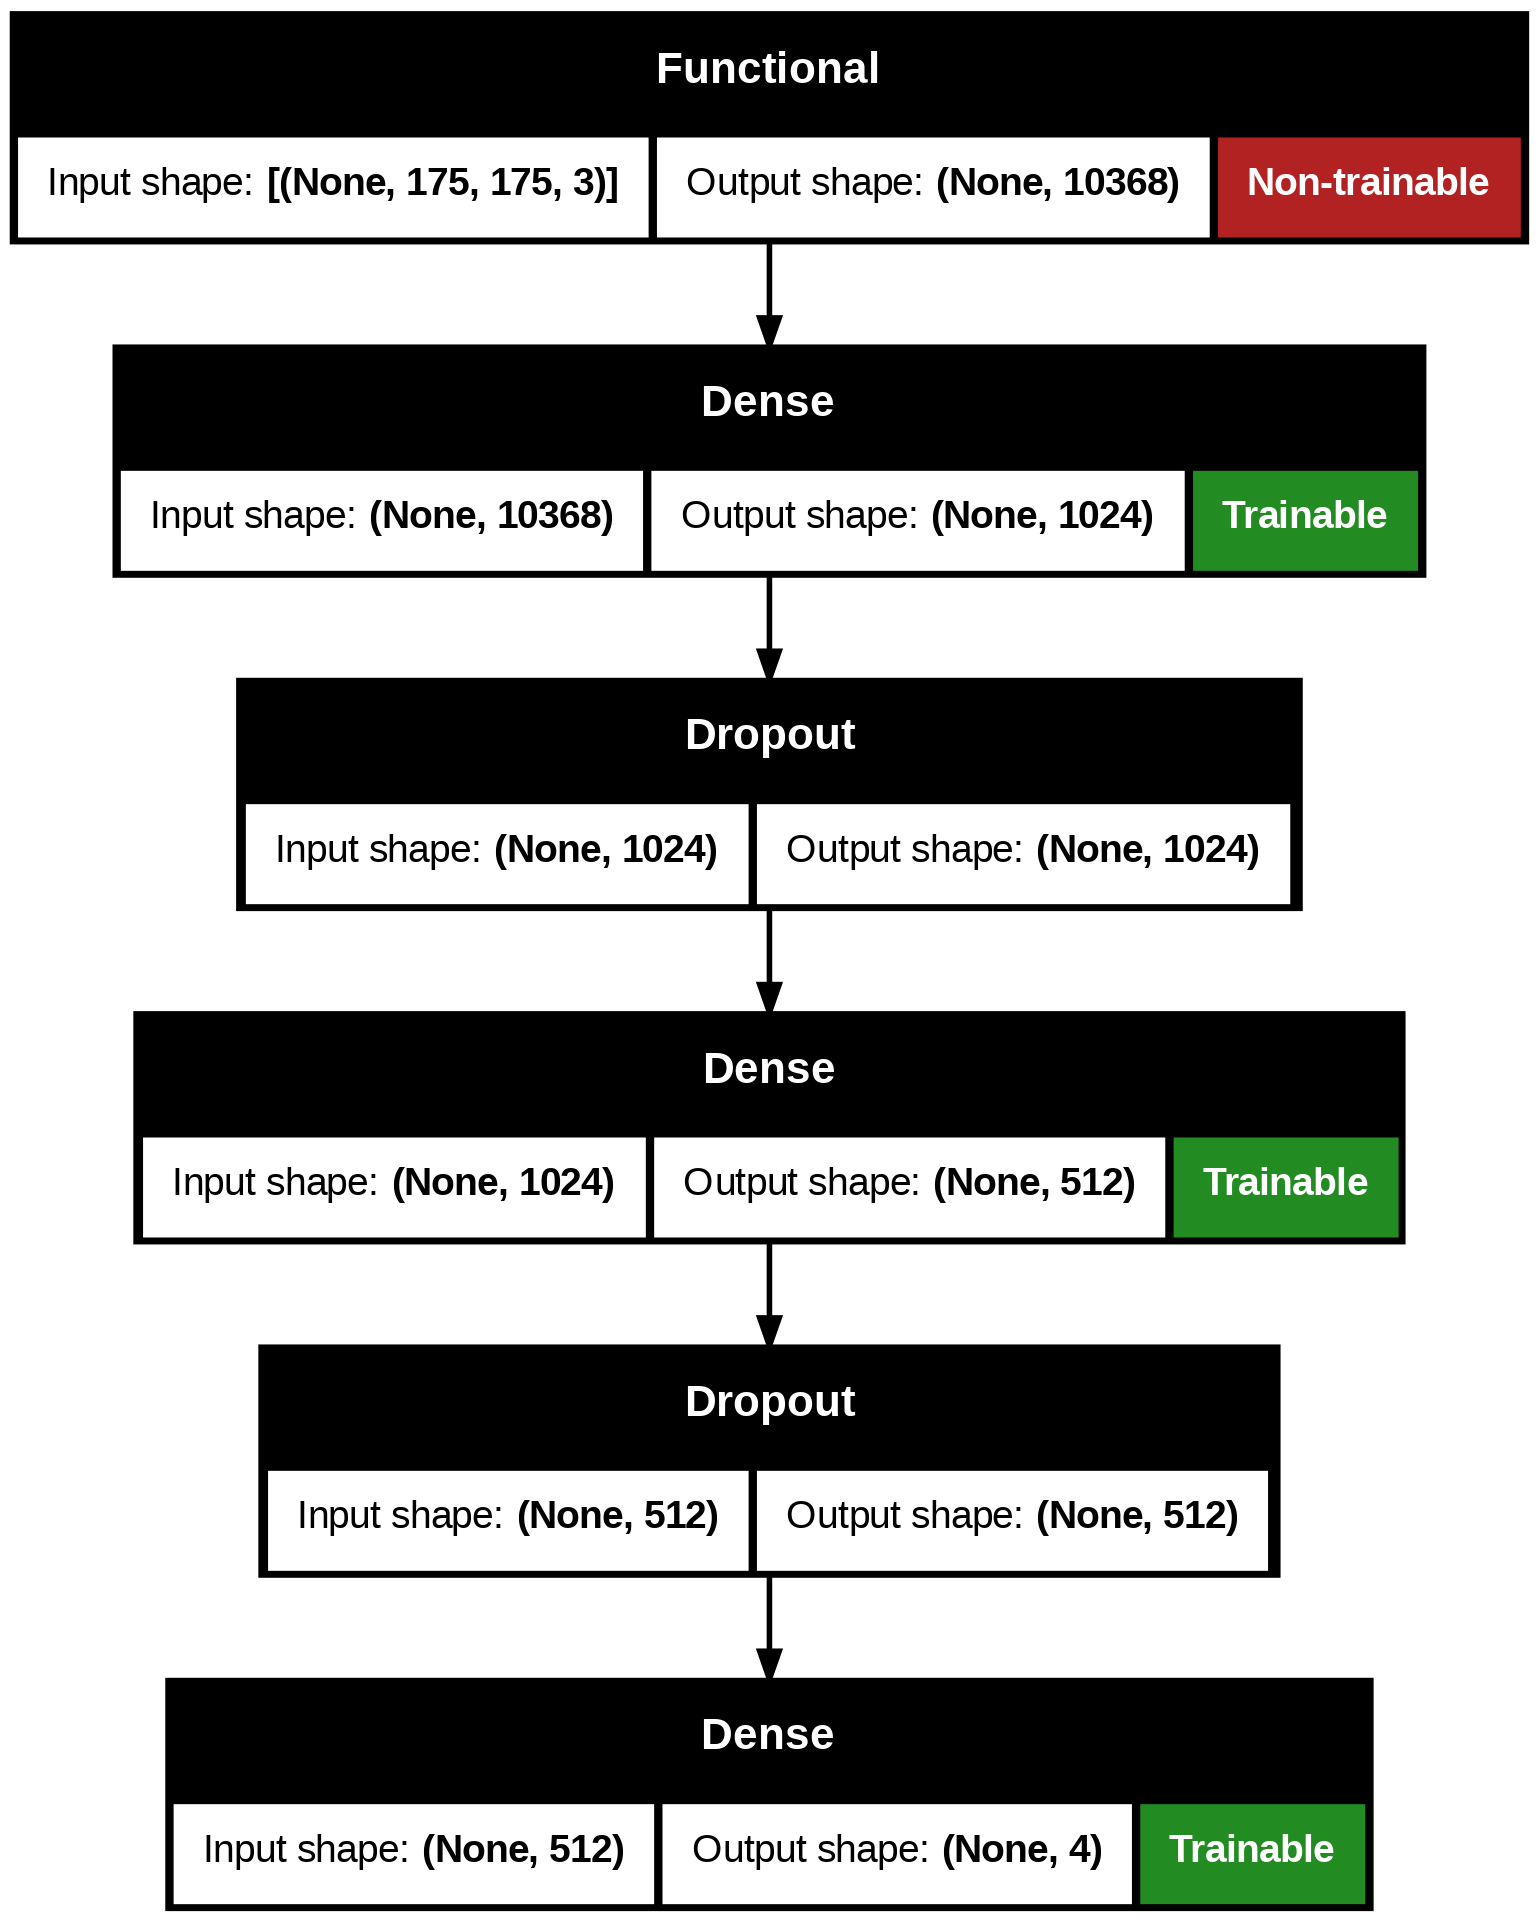

In [ ]:
cnn_model_lion_tiger = keras.Sequential([
    cnn_cats_and_dogs_conv,
    Dense(FC_LAYER_SIZE, activation='relu', kernel_regularizer = l2),
    Dropout(0.2),
    Dense(FC_LAYER_SIZE // 2, activation='relu', kernel_regularizer = l2),
    Dropout(0.2),
    Dense(4, activation="softmax")
])

cnn_model_lion_tiger.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    loss = "categorical_crossentropy",
    metrics = ['accuracy'])

cnn_model_lion_tiger.summary()
plot_model(cnn_model_lion_tiger, show_shapes = True, show_trainable = True, to_file='./out/cnn_model_lion_tiger_summary.png', dpi = 200)

In [ ]:
y_valid_all.shape

(2048, 4)

In [ ]:
lion_tiger_history = cnn_model_lion_tiger.fit(X_train_all,
    y_train_all,
    batch_size = BATCH_SIZE,
    shuffle = True,
    epochs = EPOCH_SIZE * 2,
    # We pass it validation data to
    # monitor loss and entropy during model training
    # Useful to plot graphs later!
    validation_data = (X_valid_all, y_valid_all),
    callbacks = [early_stopping])

lion_tiger_history = lion_tiger_history.history

Epoch 1/20


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(32, 1), output.shape=(32, 4)

64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 387ms/step
The F1 score for this model is 0.6840917153256899.
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 440ms/step


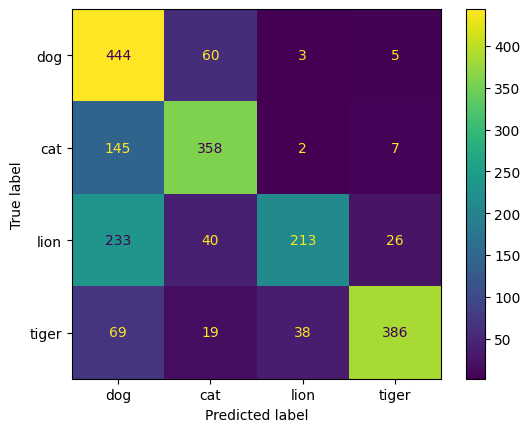

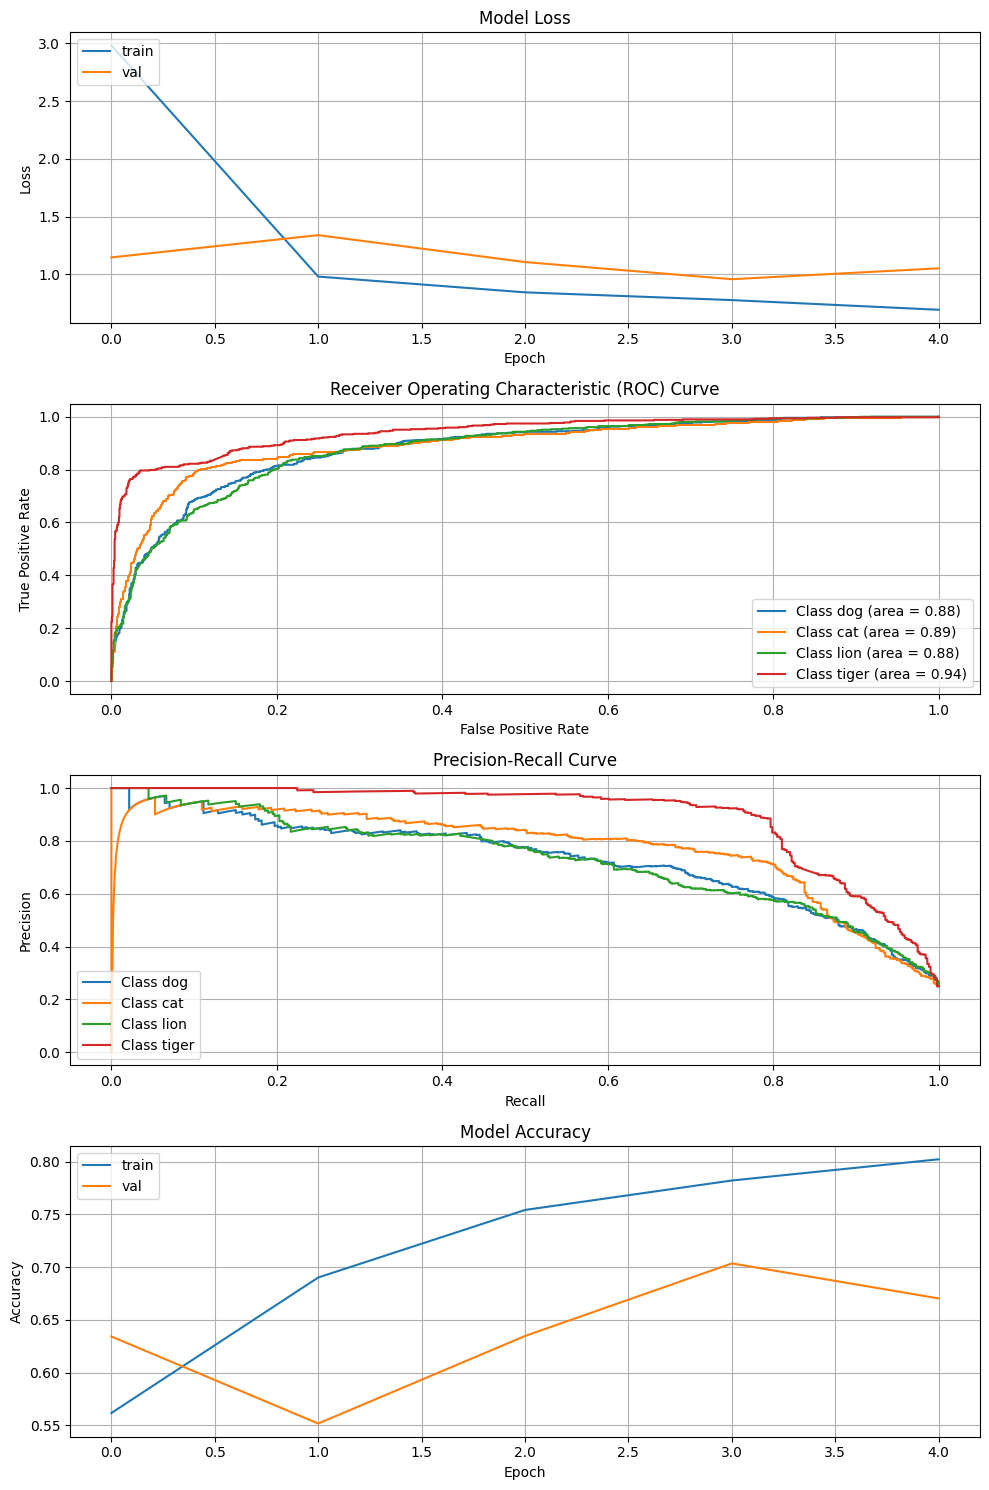

In [ ]:
print_and_save_correlation(model=cnn_model_lion_tiger, X=X_valid_all, true_preds=y_valid_all,
                           file_name='cnn_model_lion_tiger',
                           display_labels=['dog', 'cat', 'lion', 'tiger'], multiclass=True)
print_and_save_curves(model=cnn_model_lion_tiger, X_val=X_valid_all, y_val=y_valid_all,
                      file_name='cnn_model_lion_tiger', history=lion_tiger_history, multiclass=True,
                      class_names=['dog', 'cat', 'lion', 'tiger'])

As we can see, a lot of tigers are getting predicted as dogs. This is because they look so similar! To improve, we can try to add another convolutional layer before the fully-connected layer to learn complex features specific to lions and tigers such as their mane, body scales, etc.

In [ ]:
save_model(cnn_model_lion_tiger, 'cnn_model_lion_tiger', lion_tiger_history)

### With Augmentation

In [ ]:
cnn_model_lion_tiger_aug = keras.Sequential([
    cnn_cats_and_dogs_conv,
    Dense(FC_LAYER_SIZE, activation='relu', kernel_regularizer = l2),
    Dropout(0.2),
    Dense(FC_LAYER_SIZE // 2, activation='relu', kernel_regularizer = l2),
    Dropout(0.2),
    Dense(4, activation="softmax")
])

cnn_model_lion_tiger_aug.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    loss = "categorical_crossentropy",
    metrics = ['accuracy'])

In [ ]:
y_train_all.shape

(5120, 4)

In [ ]:
X_train_all.shape[0]//BATCH_SIZE

160

In [ ]:
EPOCH_SIZE

10

In [ ]:
lion_tiger_aug_history = cnn_model_lion_tiger_aug.fit(img_aug.flow(X_train_all, y_train_all, batch_size=BATCH_SIZE),
    epochs = 20, # number of images comprising of one epoch
    validation_data=(X_valid_all, y_valid_all), # data for validation,
    verbose = 1,
    callbacks = [early_stopping]) # number of images comprising of one epoch

lion_tiger_aug_history = lion_tiger_aug_history.history

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.4747 - loss: 4.3359 - val_accuracy: 0.6826 - val_loss: 1.0347
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.6208 - loss: 1.1303 - val_accuracy: 0.6094 - val_loss: 1.1563
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.6006 - loss: 1.0837 - val_accuracy: 0.4922 - val_loss: 1.2441
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.6280 - loss: 1.0228 - val_accuracy: 0.6582 - val_loss: 1.0280
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.6341 - loss: 0.9900 - val_accuracy: 0.5996 - val_loss: 1.0756
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.6432 - loss: 0.9742 - val_accuracy: 0.6592 - val_loss: 1.0694
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.6478 - loss: 0.9452 - val_accuracy: 0.6445 - val_loss: 0.9524
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.6368 - loss: 0.9417 - val_accuracy: 0.683

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step
The F1 score for this model is 0.712626605502291.
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 588ms/step


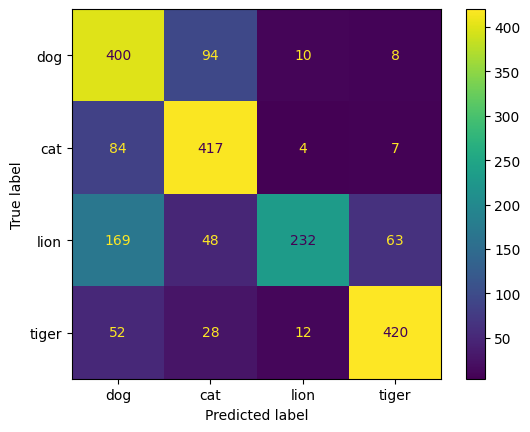

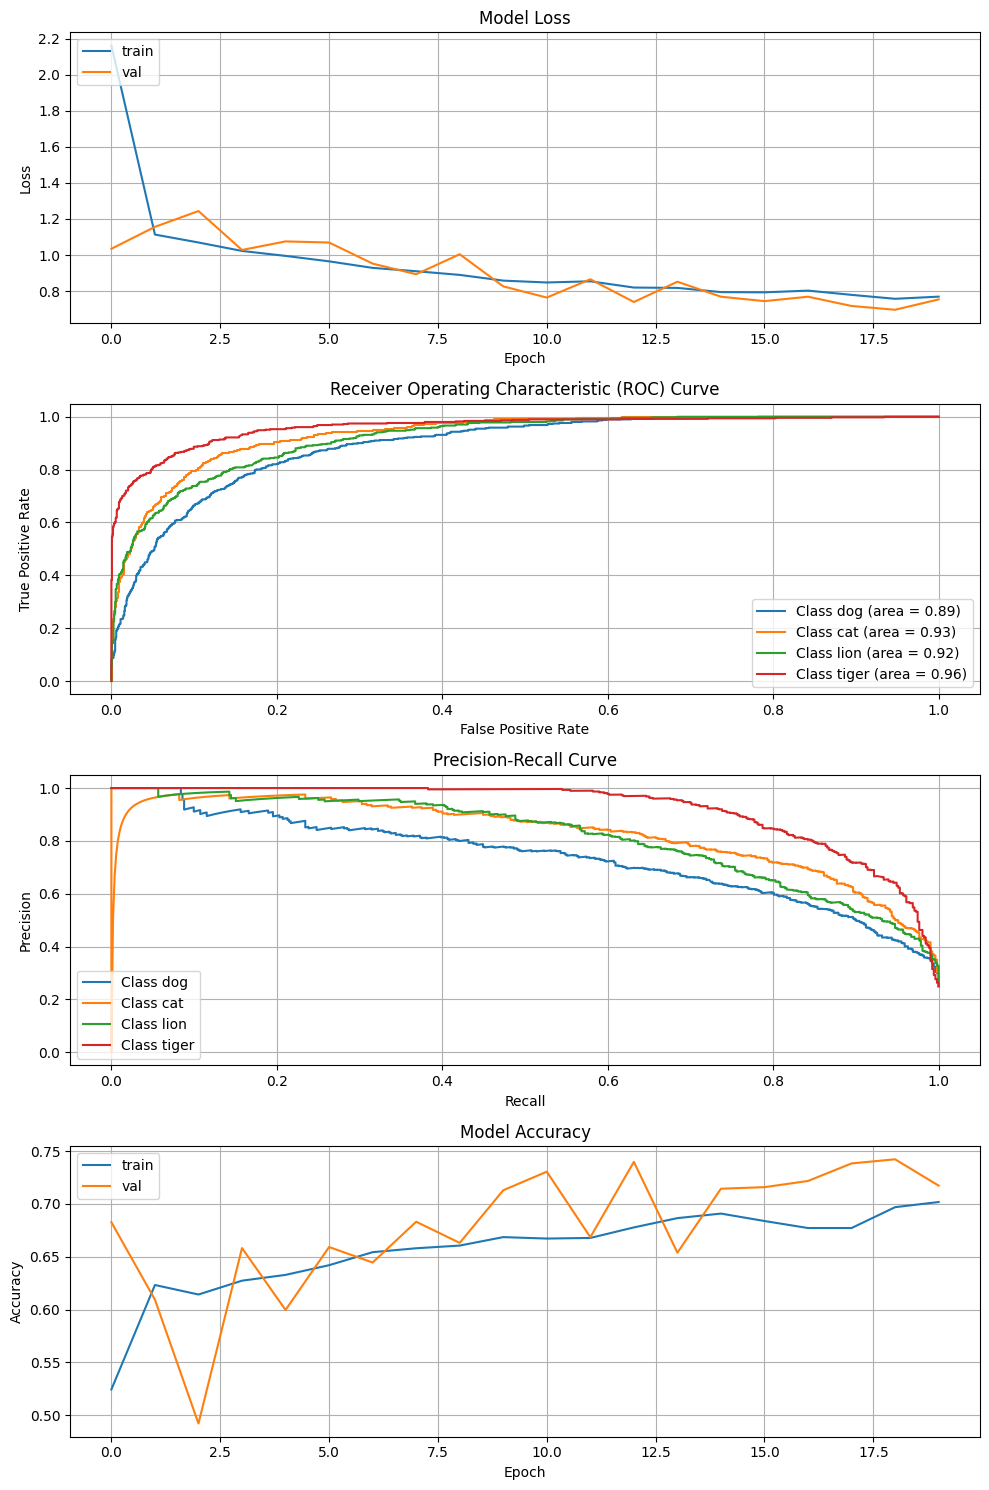

In [ ]:
print_and_save_correlation(model=cnn_model_lion_tiger_aug, X=X_valid_all, true_preds=y_valid_all,
                           file_name='cnn_model_lion_tiger_aug',
                           display_labels=['dog', 'cat', 'lion', 'tiger'], multiclass=True)
print_and_save_curves(model=cnn_model_lion_tiger_aug, X_val=X_valid_all, y_val=y_valid_all,
                      file_name='cnn_model_lion_tiger_aug', history=lion_tiger_aug_history, multiclass=True,
                      class_names=['dog', 'cat', 'lion', 'tiger'])

In [ ]:
save_model(cnn_model_lion_tiger_aug, 'cnn_model_lion_tiger_aug', lion_tiger_aug_history)

In [ ]:
history_dict = [{'name':'CNN Cats & Dogs', 'val_accuracy': history['val_accuracy'], 'val_loss': history['val_loss']},
           {'name':'CNN Lion & Tiger', 'val_accuracy': lion_tiger_history['val_accuracy'], 'val_loss': lion_tiger_history['val_loss']},
           {'name':'CNN Lion & Tiger w/ Augmentation', 'val_accuracy': lion_tiger_aug_history['val_accuracy'], 'val_loss': lion_tiger_aug_history['val_loss']}]

NameError: name 'history' is not defined

In [ ]:
def model_comparison(history_dict):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    ax1.set_title('Comparison of model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.grid(True)

    ax2.set_title('Comparison of model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.grid(True)
    for history in history_dict:
        ax1.plot(history['val_accuracy'], label = history['name'])

        ax2.plot(history['val_loss'], label=history['name'])

    ax1.legend([history['name'] for history in history_dict], loc='lower right')
    ax2.legend([history['name'] for history in history_dict], loc='upper right')

    plt.tight_layout()

    fig.savefig(f"./out/comparison.jpeg")

    plt.show()

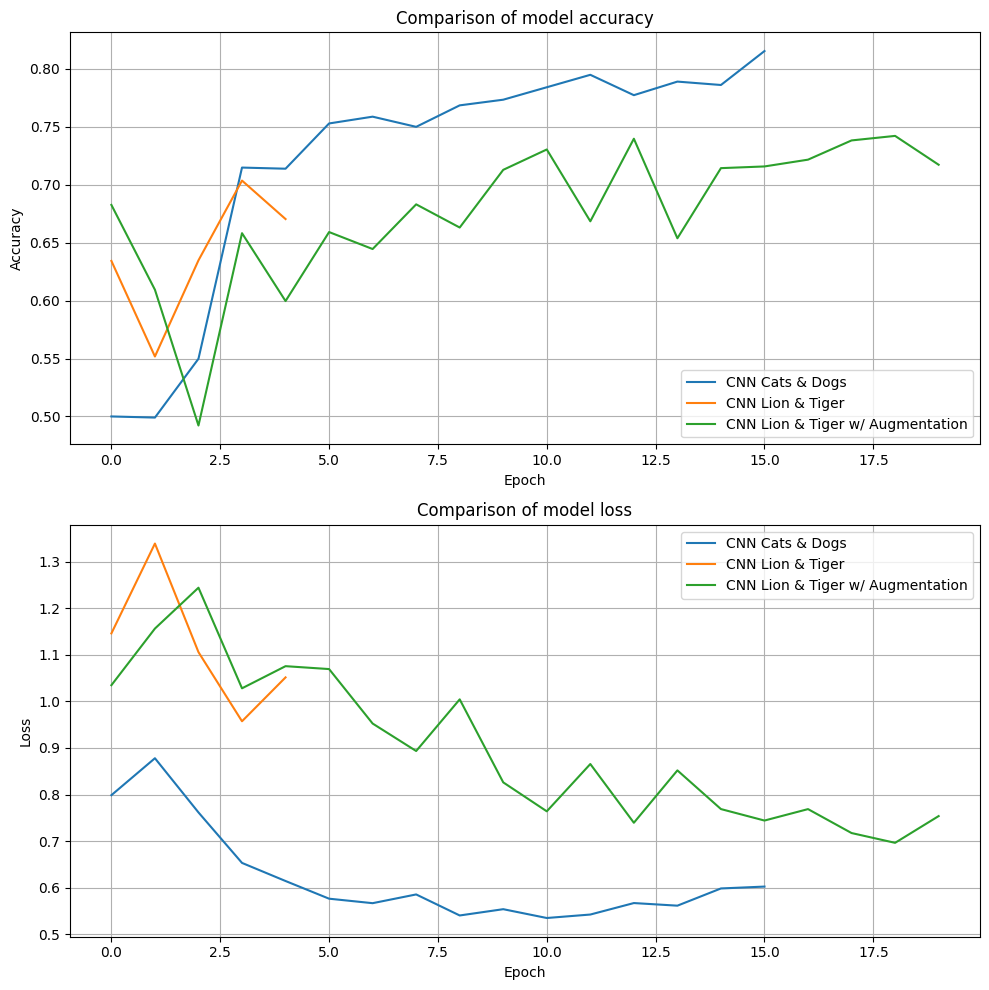

In [ ]:
model_comparison(history_dict)